# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

### Setup

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

### Q1.
 Clean the data and perform some EDA and visualization to get to know the data set.

In [3]:
df = pd.read_csv("data/pierce_county_house_sales.csv")  
df.head()


,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,view_quality,utility_sewer
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,NaN,NaN,SEWER/SEPTIC INSTALLED
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,NaN,NaN,SEWER/SEPTIC INSTALLED
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,NaN,NaN,SEWER/SEPTIC INSTALLED
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED


In [4]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16814 entries, 0 to 16813
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sale_date                    16814 non-null  object
 1   sale_price                   16814 non-null  int64 
 2   house_square_feet            16814 non-null  int64 
 3   attic_finished_square_feet   16814 non-null  int64 
 4   basement_square_feet         16814 non-null  int64 
 5   attached_garage_square_feet  16814 non-null  int64 
 6   detached_garage_square_feet  16814 non-null  int64 
 7   fireplaces                   16814 non-null  int64 
 8   hvac_description             16807 non-null  object
 9   exterior                     16813 non-null  object
 10  interior                     16807 non-null  object
 11  stories                      16814 non-null  int64 
 12  roof_cover                   16806 non-null  object
 13  year_built                   16

In [5]:
df.drop_duplicates(inplace=True)

df.drop(['waterfront_type', 'view_quality'], axis=1, inplace=True)

cat_cols = ['hvac_description', 'exterior', 'interior', 'roof_cover']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


C:\Users\kevin\AppData\Local\Temp\ipykernel_14044\2040800800.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [6]:
df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')
df['sale_year'] = df['sale_date'].dt.year
df['sale_month'] = df['sale_date'].dt.month


In [7]:
categorical_cols = ['hvac_description', 'exterior', 'interior', 
                    'roof_cover', 'utility_sewer']
df = df[df['sale_price'] < df['sale_price'].quantile(0.99)]
print(df.isnull().sum())
print(df.info())

sale_date                      0
sale_price                     0
house_square_feet              0
attic_finished_square_feet     0
basement_square_feet           0
attached_garage_square_feet    0
detached_garage_square_feet    0
fireplaces                     0
hvac_description               0
exterior                       0
interior                       0
stories                        0
roof_cover                     0
year_built                     0
bedrooms                       0
bathrooms                      0
utility_sewer                  0
sale_year                      0
sale_month                     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 16598 entries, 0 to 16813
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sale_date                    16598 non-null  datetime64[ns]
 1   sale_price                   16598 non-null  int64      

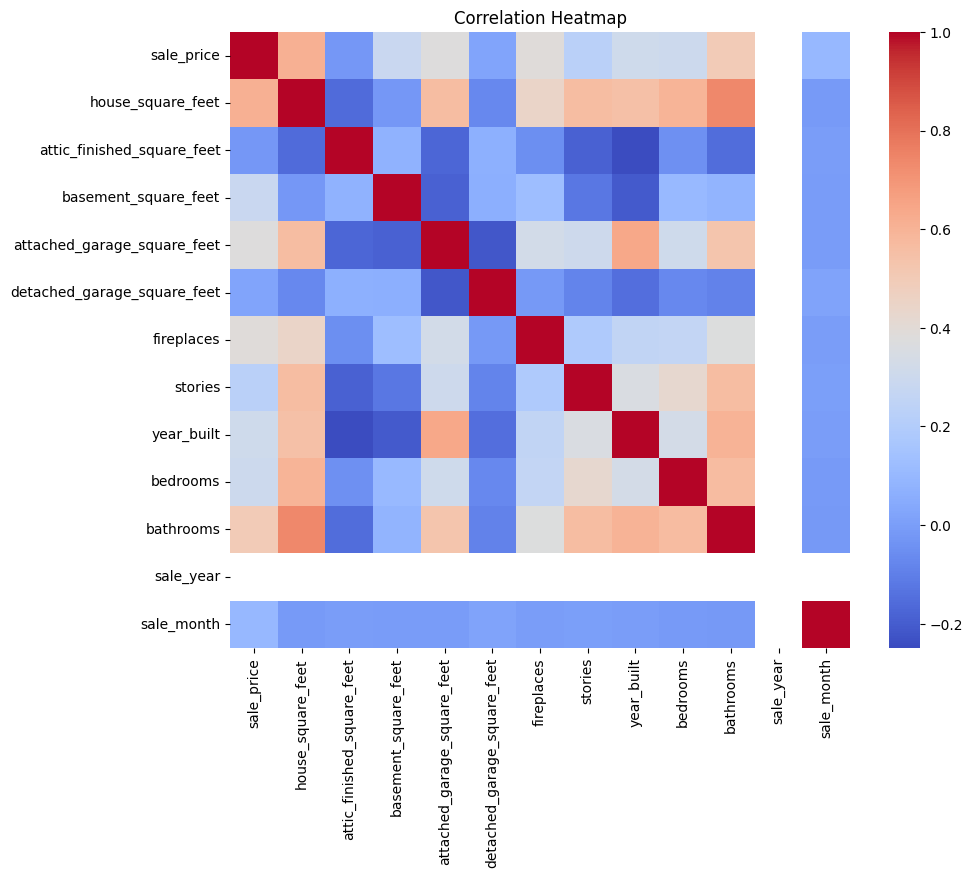

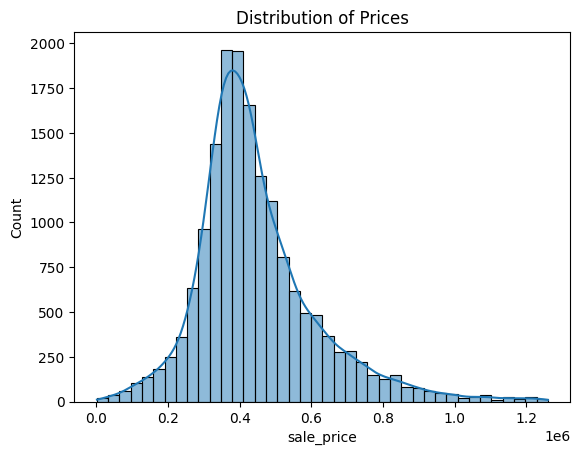

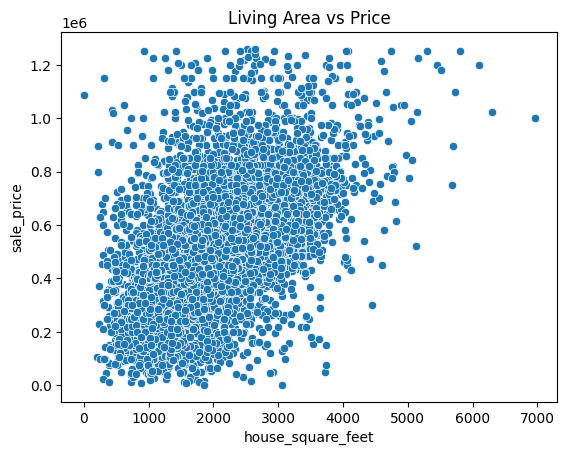

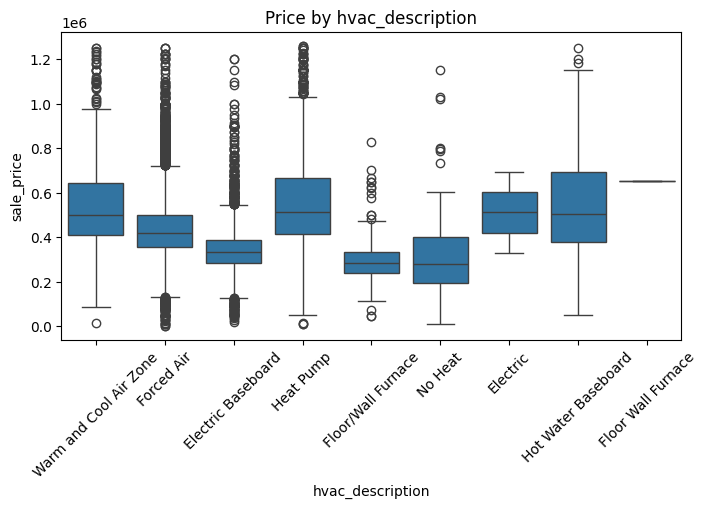

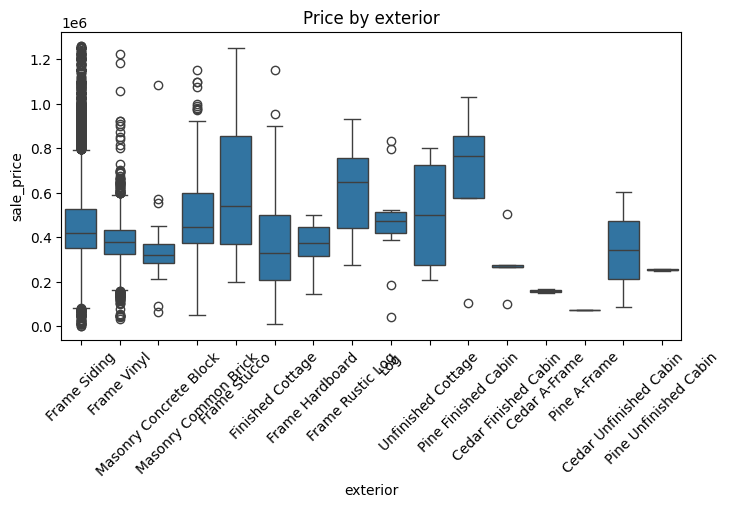

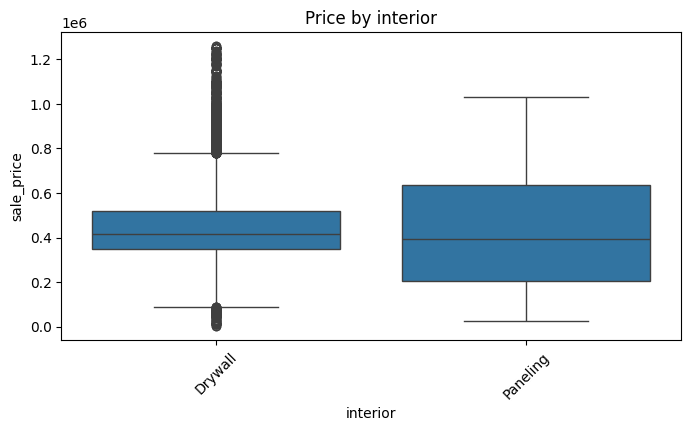

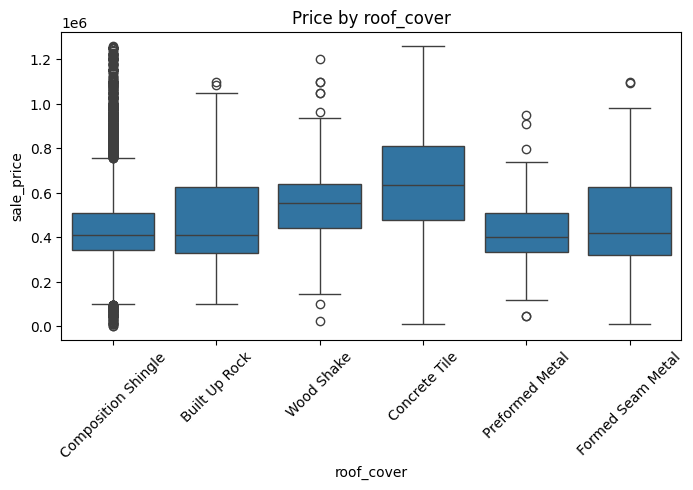

In [8]:
# corr heatmap for numeric
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

# price distr
sns.histplot(df['sale_price'], bins=40, kde=True)
plt.title("Distribution of Prices")
plt.show()

# test scatterplot idk if useful
sns.scatterplot(x='house_square_feet', y='sale_price', data=df)
plt.title("Living Area vs Price")
plt.show()

# categorical variables
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=col, y='sale_price', data=df)
    plt.title(f'Price by {col}')
    plt.xticks(rotation=45)
    plt.show()


### Q2.
Transform your variables --- particularly categorical ones --- for use in your regression analysis.

Also going to drop the `sale_date` since we've already got the `sale_month` and `sale_year` in here and the LinearRegression models later don't like datetimes.

In [9]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded = df_encoded.drop('sale_date', axis=1)

print(df_encoded.head())

   sale_price  house_square_feet  attic_finished_square_feet  \
0      380000               2157                           0   
1      383000               2238                           0   
2      419900               1452                           0   
3      251660                832                           0   
4      500000               1780                           0   

   basement_square_feet  attached_garage_square_feet  \
0                     0                          528   
1                     0                          396   
2                     0                            0   
3                     0                            0   
4                   384                          484   

   detached_garage_square_feet  fireplaces  stories  year_built  bedrooms  \
0                            0           0        2        1993         3   
1                            0           0        2        2017         4   
2                            0           1     

### Q3.
Implement an 80/20 train-test split. Put the test data aside.

In [10]:
X = df_encoded.drop('sale_price', axis=1)
y = df_encoded['sale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (13278, 45)
Test shape: (3320, 45)


### Q4.

Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

#### Model Ver. 1: All features

In [11]:
all_features_reg = LinearRegression().fit(X_train, y_train)
y_train_hat = all_features_reg.predict(X_train)
train_r2 = all_features_reg.score(X_train, y_train)
train_rmse = root_mean_squared_error(y_train, y_train_hat)
y_test_hat = all_features_reg.predict(X_test)
test_r2 = all_features_reg.score(X_test, y_test)
test_rmse = root_mean_squared_error(y_test, y_test_hat)

print(f'Train Set: R^2 = {train_r2}, RMSE = {train_rmse}')
print(f'Test Set: R^2 = {test_r2}, RMSE = {test_rmse}')

Train Set: R^2 = 0.5560191460668855, RMSE = 111801.93097959865
Test Set: R^2 = 0.5340991711189167, RMSE = 116547.4049977629


#### Model Ver. 2: Linearly Correlated Numerical Features
For this case, going to only pick out the features that seem to have a certain level of linear correlation with the predicted feature, `sale_price`. Will do this via the `.corr` function that pd has.

In [12]:
corr_mat = df_encoded.corr(numeric_only=True)
corr_mat['sale_price'].sort_values(ascending=False)

sale_price                                 1.000000
house_square_feet                          0.614252
bathrooms                                  0.498382
fireplaces                                 0.388192
attached_garage_square_feet                0.379657
year_built                                 0.309450
bedrooms                                   0.298936
basement_square_feet                       0.287395
hvac_description_Heat Pump                 0.242921
stories                                    0.228365
roof_cover_Concrete Tile                   0.166825
hvac_description_Warm and Cool Air Zone    0.159281
sale_month                                 0.099104
exterior_Frame Stucco                      0.093312
exterior_Frame Siding                      0.087885
roof_cover_Wood Shake                      0.068170
hvac_description_Hot Water Baseboard       0.055556
exterior_Frame Rustic Log                  0.033217
exterior_Masonry Common Brick              0.030672
detached_gar

Only going to take the features that have > 0.2 correlation with `sale_price`!

In [13]:
features = corr_mat[np.abs(corr_mat['sale_price']) > 0.2]['sale_price']
features = features.drop('sale_price')
features

house_square_feet                      0.614252
basement_square_feet                   0.287395
attached_garage_square_feet            0.379657
fireplaces                             0.388192
stories                                0.228365
year_built                             0.309450
bedrooms                               0.298936
bathrooms                              0.498382
hvac_description_Electric Baseboard   -0.257573
hvac_description_Heat Pump             0.242921
Name: sale_price, dtype: float64

In [14]:
feature_names = features.index.tolist()
feature_names

['house_square_feet',
 'basement_square_feet',
 'attached_garage_square_feet',
 'fireplaces',
 'stories',
 'year_built',
 'bedrooms',
 'bathrooms',
 'hvac_description_Electric Baseboard',
 'hvac_description_Heat Pump']

In [15]:
X_train_correlated = X_train[feature_names]
X_test_correlated = X_test[feature_names]

num_corr_reg = LinearRegression().fit(X_train_correlated, y_train)
y_train_hat = num_corr_reg.predict(X_train_correlated)
train_r2 = num_corr_reg.score(X_train_correlated, y_train)
train_rmse = root_mean_squared_error(y_train, y_train_hat)
y_test_hat = num_corr_reg.predict(X_test_correlated)
test_r2 = num_corr_reg.score(X_test_correlated, y_test)
test_rmse = root_mean_squared_error(y_test, y_test_hat)

print(f'Train Set: R^2 = {train_r2}, RMSE = {train_rmse}')
print(f'Test Set: R^2 = {test_r2}, RMSE = {test_rmse}')

Train Set: R^2 = 0.5225989760369749, RMSE = 115933.47576618436
Test Set: R^2 = 0.4808480775425378, RMSE = 123027.75521216531


#### Model Ver. 3x: One of Each :)
I'm losing it because I frankly don't know what else to do here, so for this one I'm going to write a for loop that builds an extremely simple SLR that tries to predict the target (`sale_price`) with each one of the features individually! Note that it'll print on each feature, but then I'll have a thing in there to also just pull the feature that ended up having the lowest of the RMSEs.

In [16]:
lowest_train_rmse_feature = None
lowest_test_rmse_feature = None
lowest_train_rmse = float('inf')
lowest_test_rmse = float('inf') 
best_train_r2 = float('-inf')
best_test_r2 = float('-inf')

for col in X_train.columns:    
    single_feature_reg = LinearRegression().fit(X_train[[col]], y_train)
    y_train_hat = single_feature_reg.predict(X_train[[col]])
    train_r2 = single_feature_reg.score(X_train[[col]], y_train)
    train_rmse = root_mean_squared_error(y_train, y_train_hat)
    y_test_hat = single_feature_reg.predict(X_test[[col]])
    test_r2 = single_feature_reg.score(X_test[[col]], y_test)
    test_rmse = root_mean_squared_error(y_test, y_test_hat)
    
    if(train_rmse < lowest_train_rmse):
        lowest_train_rmse = train_rmse
        lowest_train_rmse_feature = col
        best_train_r2 = train_r2
    if(test_rmse < lowest_test_rmse):
        lowest_test_rmse = test_rmse
        lowest_test_rmse_feature = col
        best_test_r2 = test_r2

    print(f'Feature: {col}')
    print(f'Train Set: R^2 = {train_r2}, RMSE = {train_rmse}')
    print(f'Test Set: R^2 = {test_r2}, RMSE = {test_rmse}')

Feature: house_square_feet
Train Set: R^2 = 0.38414185645082244, RMSE = 131676.2736131933
Test Set: R^2 = 0.3501764127330058, RMSE = 137642.83281566843
Feature: attic_finished_square_feet
Train Set: R^2 = 0.0005580019659032764, RMSE = 167743.60838113102
Test Set: R^2 = -0.0007624801214942689, RMSE = 170813.1784219584
Feature: basement_square_feet
Train Set: R^2 = 0.08591952334180353, RMSE = 160420.32801411662
Test Set: R^2 = 0.06845264066233281, RMSE = 164800.42832246269
Feature: attached_garage_square_feet
Train Set: R^2 = 0.14897625969493566, RMSE = 154788.26100914672
Test Set: R^2 = 0.12425462539129706, RMSE = 159788.23244426175
Feature: detached_garage_square_feet
Train Set: R^2 = 0.000671901384441953, RMSE = 167734.04982552284
Test Set: R^2 = -0.001310849080401466, RMSE = 170859.97065224926
Feature: fireplaces
Train Set: R^2 = 0.14880223703813134, RMSE = 154804.08623601386
Test Set: R^2 = 0.15671333845739077, RMSE = 156799.0698582774
Feature: stories
Train Set: R^2 = 0.05393526249

In [17]:
print(f'Lowest Train RMSE Feature: {lowest_train_rmse_feature} with RMSE = {lowest_train_rmse} and R^2 = {best_train_r2}')
print(f'Lowest Test RMSE Feature: {lowest_test_rmse_feature} with RMSE = {lowest_test_rmse} and R^2 = {best_test_r2}')

Lowest Train RMSE Feature: house_square_feet with RMSE = 131676.2736131933 and R^2 = 0.38414185645082244
Lowest Test RMSE Feature: house_square_feet with RMSE = 137642.83281566843 and R^2 = 0.3501764127330058


#### What's the best?
So honestly, just using all of the features does the best. It has the lowest RMSE/best R^2 fit of the three and it makes sense since the other two are simple linear models that reduce the feature space (so less information). I think we can maybe improve our model given transformations and interactions between features, but given that this question didn't want those I think this is good enough to move it along.

### Q5.

Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 

Honestly going to answer the second part of this question about non-linearities up here before the graphs, so you don't have to suffer scrolling all the way down past the graphs to read this. There are some 'blobbed' segments that aren't exactly following the linear line (i.e. house_square_feet has a ton of points in a rough circle) and some odd data collections (i.e. attic_finished_square_feet has a big clump around 0 presumably for those that don't have an attic, but also some linearity later), etc. I will note though that I'm not sure adding polynomial features would necessarily assist here since it's not like the reg data has some kind of curve here (i.e. not like parabolic, etc.)

Partial R^2 for house_square_feet: 0.2105443471691283


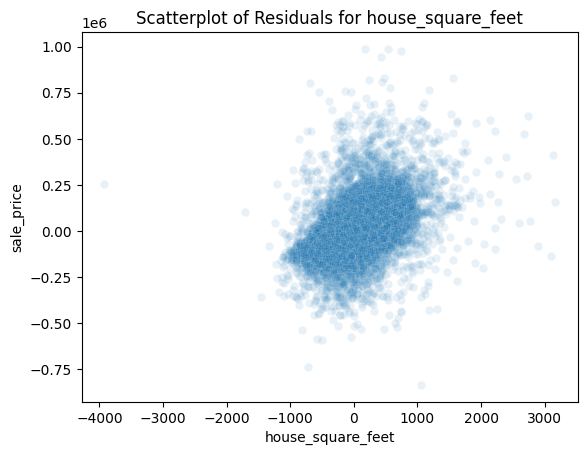

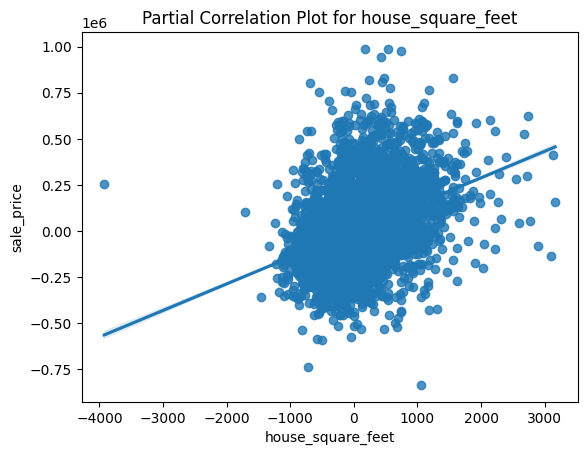

Partial R^2 for attic_finished_square_feet: 0.007109304584385856


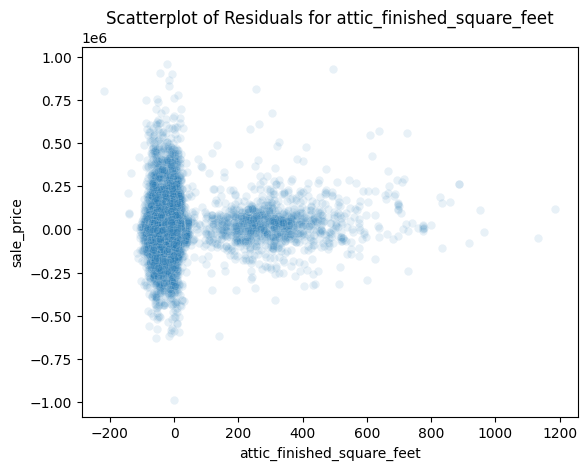

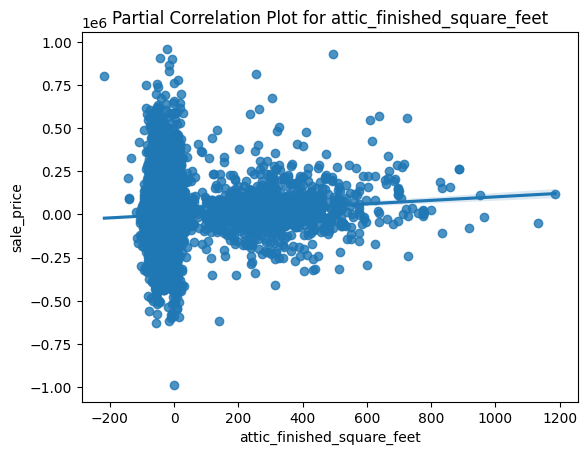

Partial R^2 for basement_square_feet: 0.13520753388215323


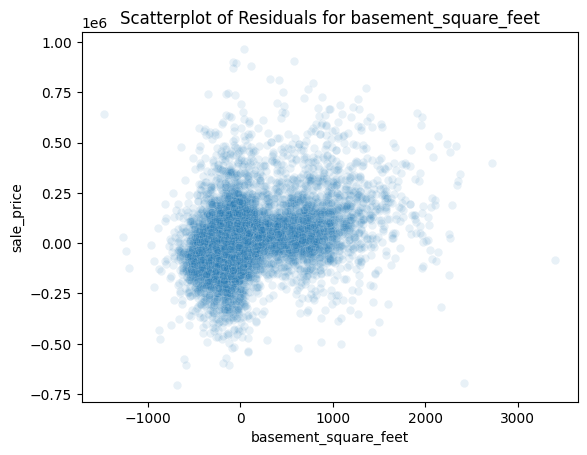

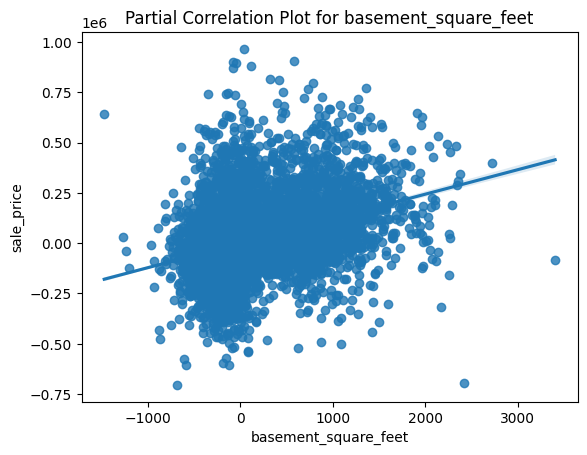

Partial R^2 for attached_garage_square_feet: 0.01602789981625108


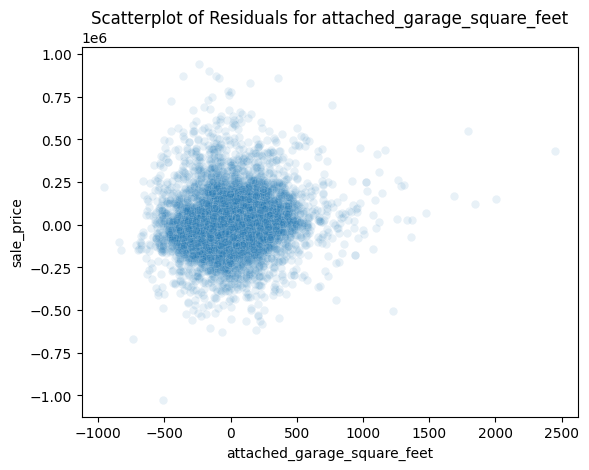

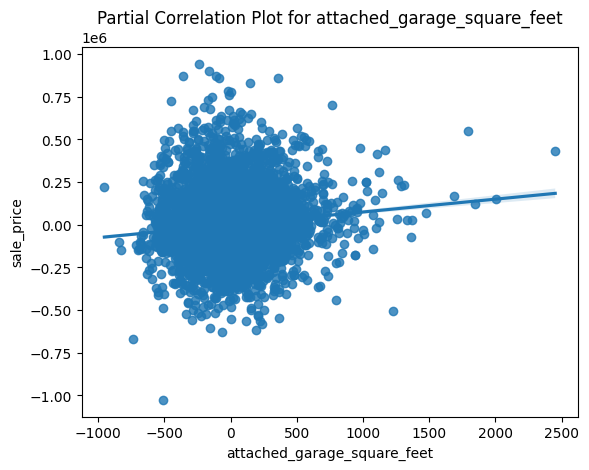

Partial R^2 for detached_garage_square_feet: 0.006776393183347884


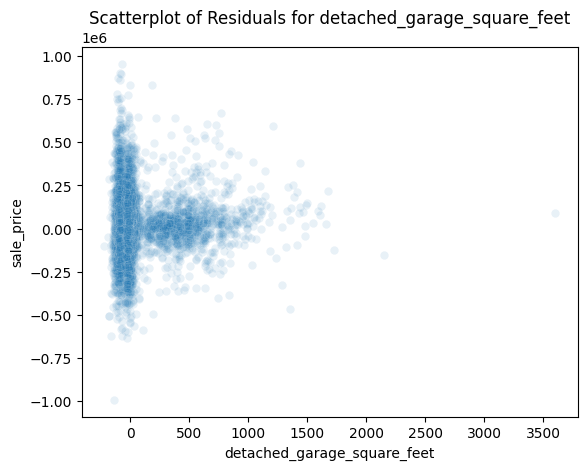

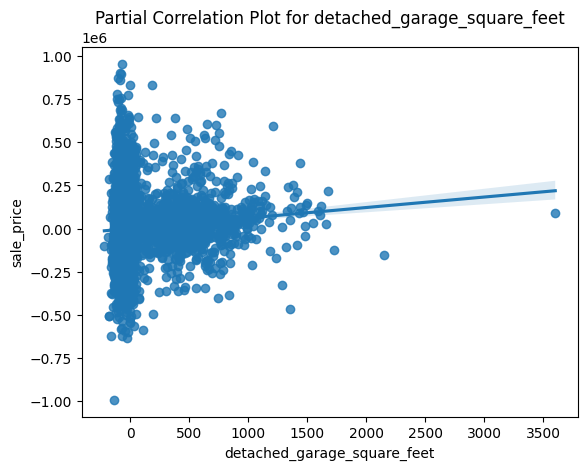

Partial R^2 for fireplaces: 0.006360437649802875


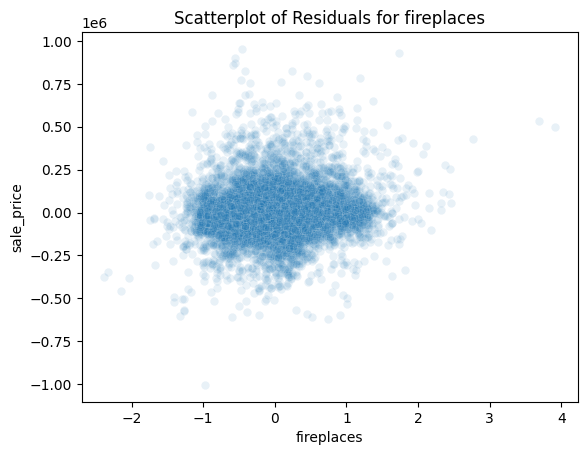

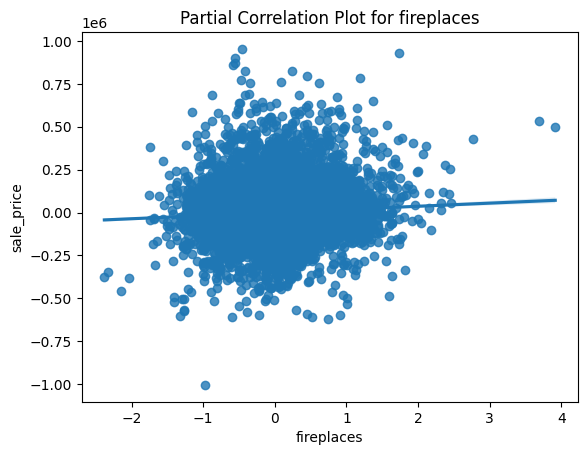

Partial R^2 for stories: 0.013116119600776077


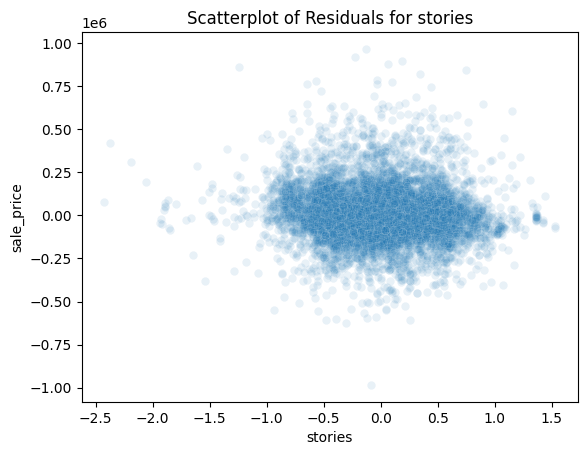

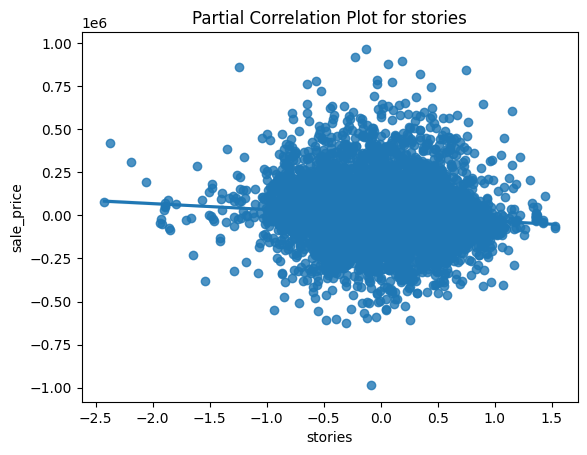

Partial R^2 for year_built: 6.938386668342567e-05


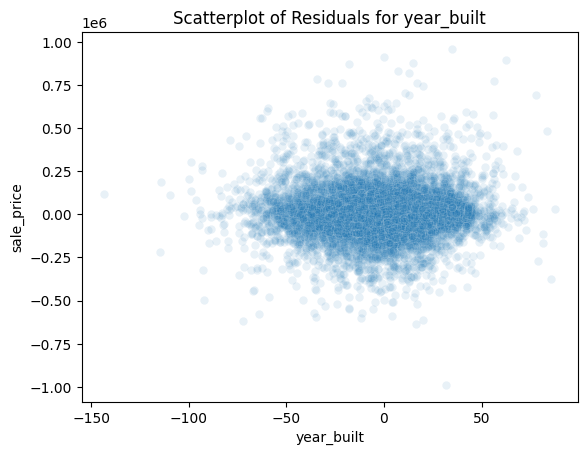

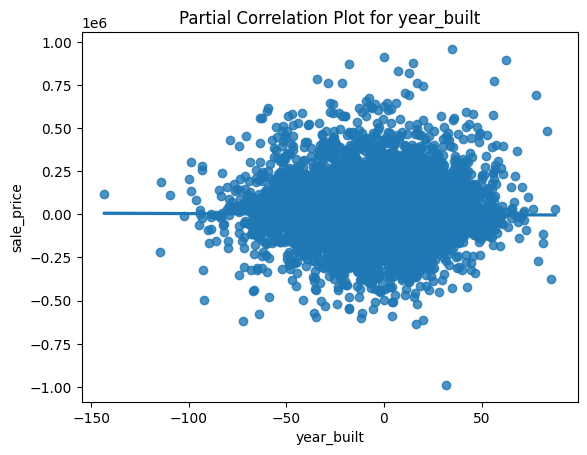

Partial R^2 for bedrooms: 0.03118314056060456


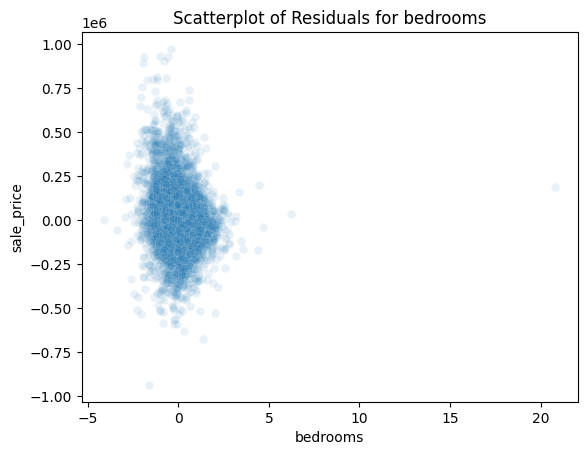

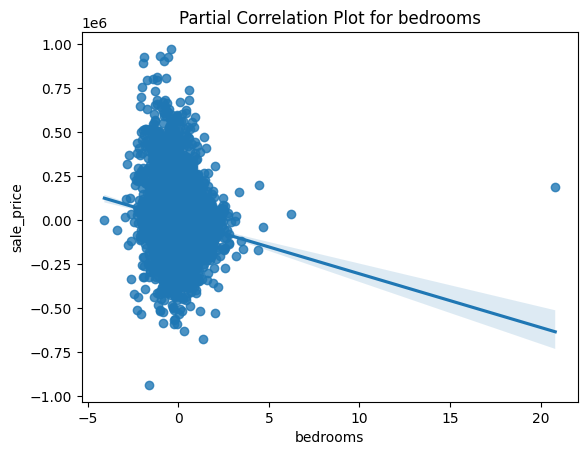

Partial R^2 for bathrooms: 0.0054347776450843766


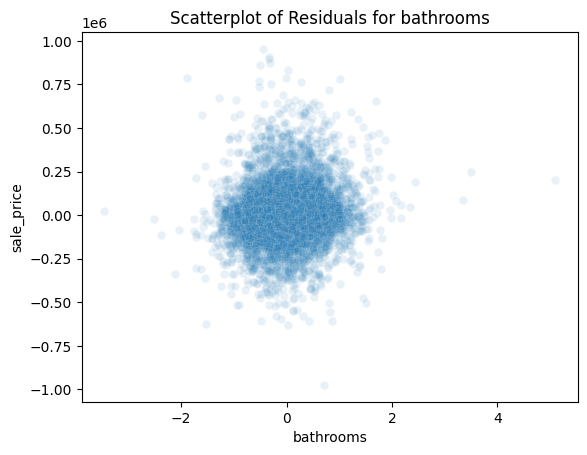

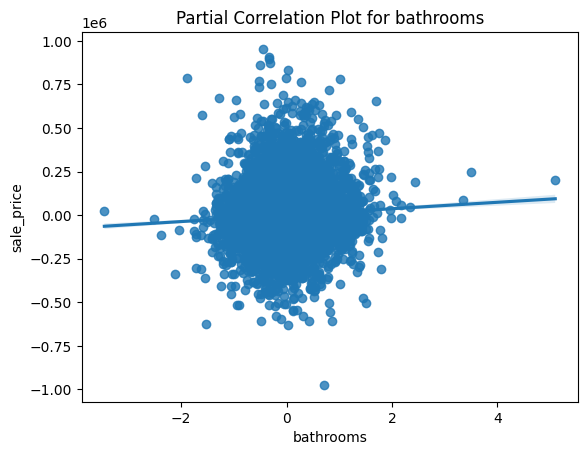

Partial R^2 for sale_year: 0.0007162188926027602


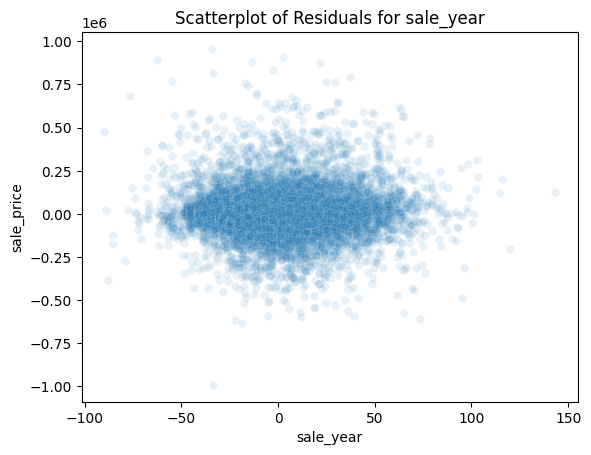

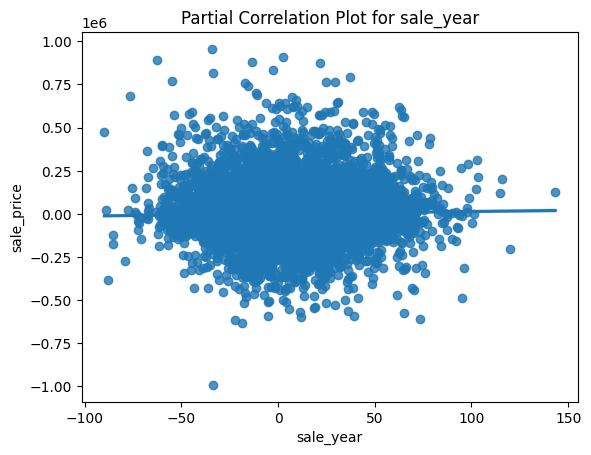

Partial R^2 for sale_month: 0.024063185046250712


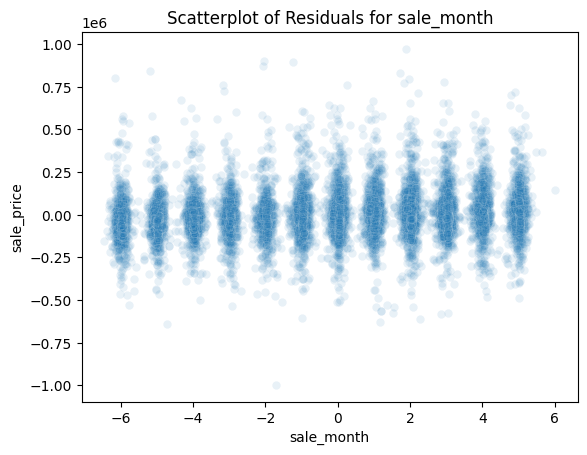

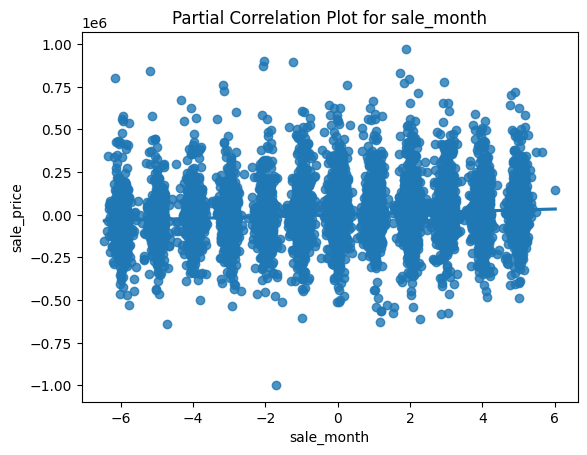

In [18]:
X = df_encoded.drop('sale_price', axis=1)
# this looks odd but essentially there's no reason to check the one hot encoded ones either
X = X[['house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet','detached_garage_square_feet', 'fireplaces', 'stories', 'year_built', 'bedrooms', 'bathrooms', 'sale_year', 'sale_month']]
y = df_encoded['sale_price']
for var in X.columns:
    x_k = X[var]
    X_mk = X.drop(var,axis=1)
    ## r_y
    reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y)
    r_y = y - reg_y.predict(X_mk)

    ## r_x
    reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k)
    r_x = x_k - reg_k.predict(X_mk)

    reg = LinearRegression().fit(r_x.to_numpy().reshape(-1, 1),r_y.to_numpy())
    print(f'Partial R^2 for {var}: {reg.score(r_x.to_numpy().reshape(-1, 1),r_y.to_numpy())}')
    sns.scatterplot(y=r_y, x=r_x,alpha=.1).set(title=f'Scatterplot of Residuals for {var}')
    plt.show()
    sns.regplot(y=r_y, x=r_x).set(title=f'Partial Correlation Plot for {var}')
    plt.show()


### Q6.

Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?

So the thing is, I didn't see any explicit non-linear trends in the above graphs. However, going to try to make some interaction terms because I think that we might have some potential there that wasn't shown in the correlation plots. Notably, I'm going to be targeting interaction terms relative to house value - i.e. feature engineer stuff like square feet / bedrooms (how much square feet per bedroom - is it a massive house with a ton of bedrooms, a tiny house with only one bedroom? etc.), bathrooms * bedrooms (often houses have a lot more bedrooms than bathrooms), etc. you get the idea. I'm also going to standard scaler the numericals, because why not.

In [ ]:
# numba one: interaction terms creation
engineered_features = df_encoded.copy()
engineered_features['sqft_per_bedroom'] = engineered_features['house_square_feet'] / engineered_features['bedrooms'].replace(np.inf, 0)
engineered_features['bathrooms_times_bedrooms'] = engineered_features['bathrooms'] * engineered_features['bedrooms']
engineered_features['stories_times_sqft'] = engineered_features['stories'] * engineered_features['house_square_feet']
engineered_features['age'] = engineered_features['year_built'].max() - engineered_features['year_built']
engineered_features['sqft_by_age'] = engineered_features['house_square_feet'] * engineered_features['age']
# have to do the below because there are some houses with no bedrooms which causes inf due to divide by zero
engineered_features['sqft_per_bedroom'] = engineered_features['sqft_per_bedroom'].replace([np.inf], 0)

X = engineered_features.drop('sale_price', axis=1)
y = engineered_features['sale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# numba two: normalization scaling the categoricals
numericals_to_scale = ['house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces',  'stories', 'year_built', 'bedrooms', 'bathrooms',  'sale_year', 'sale_month', 'sqft_per_bedroom', 'bathrooms_times_bedrooms', 'stories_times_sqft', 'age', 'sqft_by_age']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numericals_to_scale] = scaler.fit_transform(X_train[numericals_to_scale])
X_test_scaled = X_test.copy()
X_test_scaled[numericals_to_scale] = scaler.transform(X_test[numericals_to_scale])

nonlinear_reg = LinearRegression().fit(X_train_scaled, y_train)
y_train_hat = nonlinear_reg.predict(X_train_scaled)
train_r2 = nonlinear_reg.score(X_train_scaled, y_train)
train_rmse = root_mean_squared_error(y_train, y_train_hat)
y_test_hat = nonlinear_reg.predict(X_test_scaled)
test_r2 = nonlinear_reg.score(X_test_scaled, y_test)
test_rmse = root_mean_squared_error(y_test, y_test_hat)

print(f'Train Set: R^2 = {train_r2}, RMSE = {train_rmse}')
print(f'Test Set: R^2 = {test_r2}, RMSE = {test_rmse}')

Train Set: R^2 = 0.5590900335993415, RMSE = 111414.60921152018
Test Set: R^2 = 0.5352918495148494, RMSE = 116398.13219367291


The more complex model with interaction terms and numerical normalization ends up performing marginally better on both the train and test sets, meaning that the changes to increase the complexity of the linear regression model ended up helping a tiny bit in predicting house prices a little better.